<a href="https://colab.research.google.com/github/shcho11/00.Projects_KoreaUniv_2023-1/blob/main/202303_RS_RecommenderSystem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **추천시스템 실습(평점기반)**
**┗ 다양한 통계적 기법을 활용한 추천시스템 실습**
---

[실습과정]
1. MovieLens 데이터셋 불러오기
2. MovieLens 데이터셋 중 학습셋과 평가셋 분할
3. 추천 알고리즘 만들기(평점예측) 
4. 예측한 평점을 RMSE로 평가

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys 
print(sys.version)

3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


In [3]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings("ignore")

> ## [STEP-1] MovieLens 데이터셋 불러오기

- 😃 https://grouplens.org/datasets/movielens/
- 😃 ratings.csv, movies.csv, tags.csv

> ### 1.1) Data Collection

In [4]:
!ls -a

.  ..  .config	drive  sample_data


In [5]:
path = 'drive/MyDrive/202301_RS/movielens/'

In [6]:
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding='utf-8')
movies_df = pd.read_csv(os.path.join(path, 'movies.csv'), index_col='movieId', encoding='utf-8')
tags_df = pd.read_csv(os.path.join(path, 'tags.csv'), encoding='utf-8')

In [7]:
print(ratings_df.shape)
display(ratings_df.head())

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
print(movies_df.shape)
display(movies_df.head())

(9742, 2)


,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [9]:
print(tags_df.shape)
display(tags_df.head())

(3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### 1.2) EDA : Ratings df

* 1) 몇 명의 user가(중복제외) 몇 개의 영화에 평점을 줬는지 확인
* 2) 각 user가 어떤 영화에 평점을 줬는지 확인 
* 3) 희소행렬변환(csr_matrix)

> **[Reference]**

```
* pandas dataframe의 pivot: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html

* csr_matrix : https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

```  

In [10]:
print(ratings_df.columns)

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [11]:
num_users = ratings_df['userId'].unique()
num_movies = ratings_df['movieId'].unique()

print("총 유저 수: ", len(num_users))
print("총 영화 수: ", len(num_movies))

총 유저 수:  610
총 영화 수:  9724


In [12]:
ratings_dist = pd.DataFrame(ratings_df['rating'].value_counts()).sort_index(ascending = False)
ratings_dist.rename(columns={'rating':'n_users by ratings'}, inplace=True)
ratings_dist

,n_users by ratings
5.0,13211
4.5,8551
4.0,26818
3.5,13136
3.0,20047
2.5,5550
2.0,7551
1.5,1791
1.0,2811
0.5,1370


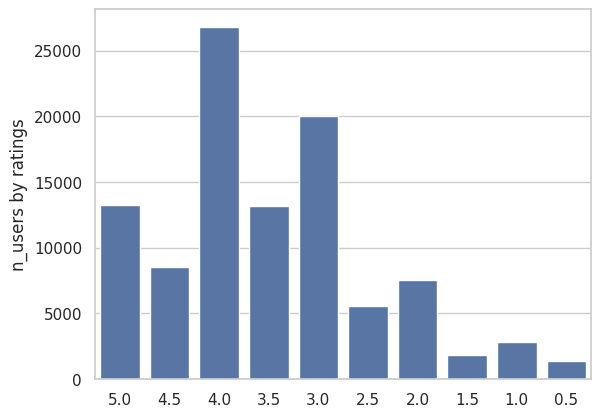

In [13]:
from matplotlib import pyplot as plt 
import seaborn as sns 

sns.set_theme(style = 'whitegrid')
x = ratings_dist.index
y = ratings_dist.iloc[:,0]

sns.barplot(data=ratings_dist, 
            x=x,
            y=y, 
            color='b',
            order=x)
plt.show()

In [14]:
# pivot ratings into movie features
# user-item matrix 

user_movie_matrix = ratings_df.pivot(index='movieId',
                                     columns='userId',
                                     values='rating').fillna(0)

In [15]:
user_movie_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
user_movie_matrix.iloc[:,0].value_counts()

0.0    9492
5.0     124
4.0      76
3.0      26
2.0       5
1.0       1
Name: 1, dtype: int64

In [17]:
# convert dataframe of movie features to scipy sparse matrix - 희소행렬변환
# csr: abv of "Compressed Sparce Row" Matrix

sparse_mat = csr_matrix(user_movie_matrix.values)
print(sparse_mat) #csr_matrix 표현법(참고)

  (0, 0)	4.0
  (0, 4)	4.0
  (0, 6)	4.5
  (0, 14)	2.5
  (0, 16)	4.5
  (0, 17)	3.5
  (0, 18)	4.0
  (0, 20)	3.5
  (0, 26)	3.0
  (0, 30)	5.0
  (0, 31)	3.0
  (0, 32)	3.0
  (0, 39)	5.0
  (0, 42)	5.0
  (0, 43)	3.0
  (0, 44)	4.0
  (0, 45)	5.0
  (0, 49)	3.0
  (0, 53)	3.0
  (0, 56)	5.0
  (0, 62)	5.0
  (0, 63)	4.0
  (0, 65)	4.0
  (0, 67)	2.5
  (0, 70)	5.0
  :	:
  (9700, 337)	2.5
  (9701, 337)	3.0
  (9702, 183)	4.0
  (9702, 247)	3.5
  (9703, 317)	2.5
  (9704, 209)	1.0
  (9705, 461)	2.5
  (9706, 49)	3.5
  (9707, 337)	1.5
  (9708, 337)	4.0
  (9709, 337)	1.0
  (9710, 337)	1.5
  (9711, 337)	1.0
  (9712, 337)	1.0
  (9713, 183)	4.5
  (9714, 183)	3.5
  (9715, 183)	3.0
  (9716, 183)	4.0
  (9717, 183)	4.0
  (9718, 183)	3.5
  (9719, 183)	4.0
  (9720, 183)	3.5
  (9721, 183)	3.5
  (9722, 183)	3.5
  (9723, 330)	4.0


> **✔ user 별 영화 평점 갯수 확인**

In [18]:
user_info_df = pd.DataFrame(data = [sum(list(user_movie_matrix[int(x)].value_counts())[1:]) for x in user_movie_matrix.columns],
                            index = user_movie_matrix.columns, 
                            columns=['movies_rated'])

---
[참고]

In [22]:
print(list(user_movie_matrix[1].value_counts()))
print(sum(list(user_movie_matrix[1].value_counts())[1:]))

[9492, 124, 76, 26, 5, 1]
232


---

In [23]:
user_info_df #user 별 영화 평점 갯수

,movies_rated
userId,
1,232
2,29
3,39
4,216
5,44
...,...
606,1115
607,187
608,831


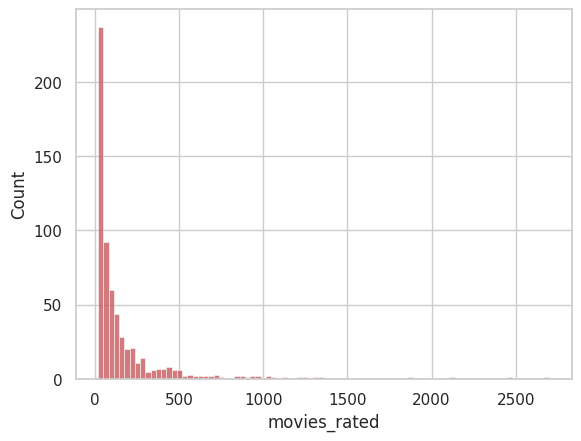

In [34]:
x1 = user_info_df.iloc[:,0]

sns.histplot(data=user_info_df, 
             x=x1,
             color='r')
plt.show()

---
> **✔ 영화별 몇명이 평점 하였는지 확인**   
> **✔ 유저수가 적은 영화는 신뢰도 측면에서 신뢰도가 낮다고 평가 할 수 있음**
  - ex)쇼핑몰 상품 평점은 높은데 평점을 단 사람이 적거나, 리뷰수가 적은 경우

In [24]:
movie_info_df = pd.DataFrame(data = [sum(list(user_movie_matrix.loc[int(x)].value_counts())[1:]) for x in user_movie_matrix.index],
                             index = user_movie_matrix.index,
                             columns=['users_rated'])

In [25]:
movie_info_df.sort_values(by='users_rated', ascending=False)

,users_rated
movieId,
356,329
318,317
296,307
593,279
2571,278
...,...
4093,1
4089,1
58351,1


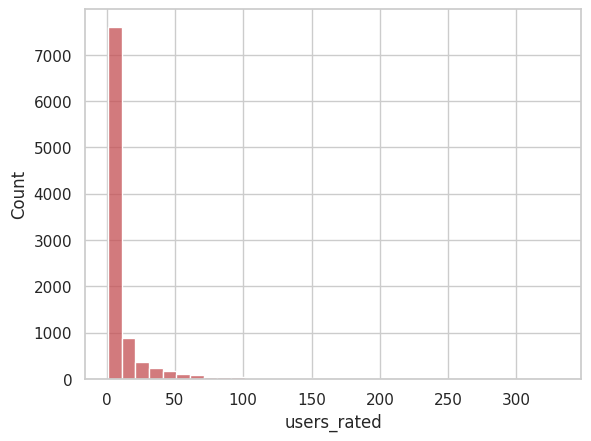

In [40]:
x2 = movie_info_df.iloc[:,0]

sns.histplot(data=movie_info_df,  
             x=x2,
             binwidth=10,
             color='r')
plt.show()

- 영화평점 수 <= 2개

In [26]:
movie_info_df[movie_info_df['users_rated'] <= 2].count()

users_rated    4744
dtype: int64

> ## [STEP-2] MovieLens 데이터셋 중 학습셋과 평가셋 분할

In [27]:
ratings_df.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


- sklearn.model_selection.train_test_split 활용
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

- random_state : 항상 동일한 테스트셋

In [28]:
train_df, test_df = train_test_split(ratings_df, test_size = 0.2, random_state = 1234)

In [29]:
print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


> ## [STEP-3] 추천 알고리즘 만들기(평점기반) 

3.1) 랜덤으로 평점 예측   
3.2) 영화별 평균 평점기반 예측   
3.3) 사용자 평균 평점기반 예측   
3.4) 영화 장르별 평점기반 예측   
3.5) 사용자 평균 평점기반 -> normalize 처리
    


### 3.1) 랜덤으로 평점 예측

In [30]:
ratings_range = np.arange(0.5, 5.5, step=0.5) # 0.5 - 5.0사이의 숫자를 생성
ratings_range

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [41]:
import random

predict_random = [random.choice(ratings_range) for x in range(len(test_df))]
predict_random[:10]

[4.0, 0.5, 1.0, 2.0, 2.5, 2.0, 2.0, 3.0, 2.5, 2.5]

In [42]:
test_df['predict_ratings_random'] = predict_random

In [43]:
test_df

,userId,movieId,rating,timestamp,predict_ratings_random
99731,610,3527,5.0,1479545223,4.0
97583,606,1250,3.5,1171376891,0.5
38197,262,213,5.0,840310907,1.0
11474,68,69406,3.0,1261622505,2.0
34105,232,4728,3.0,1218166950,2.5
...,...,...,...,...,...
41080,279,593,4.0,1506394242,2.5
4897,31,780,4.0,850466616,1.5
8023,56,410,3.0,835799188,1.0
77467,483,2291,4.0,1415579167,2.5


In [44]:
mse = mean_squared_error(y_true=test_df['rating'].values, y_pred=test_df['predict_ratings_random'].values)
rmse = np.sqrt(mse)

print(mse, rmse)

3.7285427409758034 1.9309434846664475


###  3.2) 영화별 평균 평점기반 예측

1. train set의 모든 영화에 대해서 평균 평점 구하기
2. test set 예측할 때, train set의 영화 평균 평점 활용하기. 만약 없다면, random으로 선택하기.
3. test set에는 있지만 train set 에는 없는 영화들 ~

In [45]:
train_movie_df = train_df.groupby('movieId').mean() # 영화별 평균 평점 ~

print(train_movie_df.shape)
print(train_movie_df.head())

(8938, 3)
             userId    rating     timestamp
movieId                                    
1        307.473373  3.893491  1.128439e+09
2        327.475610  3.396341  1.142893e+09
3        266.386364  3.454545  9.900434e+08
4        192.750000  2.250000  8.425133e+08
5        309.526316  3.039474  1.007415e+09


In [46]:
# train_movie_df(영화별 평균 평점) df에서 평균 평점을 가져오기 위한 def.

def avg_rating_prediction(training_set, x):
    if x in training_set.index: #train_set 에 해당 영화가 있는 경우
        pred_rating = training_set.loc[x]['rating']
    else:
        pred_rating = random.choice(ratings_range)
    return pred_rating

In [47]:
test_df['predict_rating_movie_avg'] = test_df['movieId'].apply(lambda x: avg_rating_prediction(train_movie_df, x))

test_df.head()

,userId,movieId,rating,timestamp,predict_ratings_random,predict_rating_movie_avg
99731,610,3527,5.0,1479545223,4.0,3.604167
97583,606,1250,3.5,1171376891,0.5,4.180556
38197,262,213,5.0,840310907,1.0,3.750000
11474,68,69406,3.0,1261622505,2.0,3.571429
34105,232,4728,3.0,1218166950,2.5,2.769231


In [48]:
# 잘 가져 왔는지 확인차 ~
train_movie_df.loc[3527]['rating']

3.6041666666666665

In [49]:
mse = mean_squared_error(y_true=test_df['rating'].values, y_pred=test_df['predict_rating_movie_avg'].values)
rmse = np.sqrt(mse)

print(mse, rmse)

1.054004082874999 1.0266470098699938


### 3.3) 사용자 평균 평점기반 예측


1. train set의 모든 유저가 준 평균 평점
2. test set 예측할 때, 유저가 train set에서 준 평균 평점을 활용. 유저가 없을 경우 random 평점 적용

In [50]:
train_user_df = train_df.groupby('userId').mean()

print(train_user_df.shape)
print(train_user_df.head())

(610, 3)
             movieId    rating     timestamp
userId                                      
1        1891.168478  4.320652  9.649865e+08
2       70402.760000  3.940000  1.445715e+09
3        8394.733333  2.516667  1.306464e+09
4        1957.923077  3.631868  9.655941e+08
5         337.606061  3.636364  8.474351e+08


In [51]:
test_df['predict_rating_user_avg'] = test_df['userId'].apply(lambda x: avg_rating_prediction(train_user_df, x))

test_df.head()

,userId,movieId,rating,timestamp,predict_ratings_random,predict_rating_movie_avg,predict_rating_user_avg
99731,610,3527,5.0,1479545223,4.0,3.604167,3.678709
97583,606,1250,3.5,1171376891,0.5,4.180556,3.649718
38197,262,213,5.0,840310907,1.0,3.750000,2.925000
11474,68,69406,3.0,1261622505,2.0,3.571429,3.229331
34105,232,4728,3.0,1218166950,2.5,2.769231,3.242268


In [52]:
mse = mean_squared_error(y_true=test_df['rating'].values, y_pred=test_df['predict_rating_user_avg'].values)
rmse = np.sqrt(mse)

print(mse, rmse)

#test set에 있는 user는 train set user에 다 있었음

0.8905889036428333 0.9437101798978504


### 3.4) 영화 장르별 평점기반 예측

1. train set에 포함된 유저의 영화 평균 평점과 영화의 장르를 활용하여, 장르별 평균 평점 계산 -> test set의 영화 장르의 평균 평점으로 예측

In [62]:
# create user_movie matrix by only using train_df

train_user_movie_matrix = train_df.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

In [63]:
train_user_movie_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,0.0,2.5,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,0.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- https://datascienceparichay.com/article/pandas-get-dummies-function/

In [64]:
genres_df = movies_df['genres'].str.get_dummies(sep='|')
#print(genres_df.shape)
genres_df = genres_df.loc[train_df.movieId.unique()] #train_df만 본다는 것
#print(genres_df.shape)
genres_df.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
5943,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2571,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
8958,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2322,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2959,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0


In [65]:
# trainset에서 영화별 사용자 평점 평균

train_movie_avg_ratings_df = train_user_movie_matrix.copy()
train_movie_avg_ratings_df = train_movie_avg_ratings_df.replace(0, np.NaN) # (평점이 0으로 되어 있는 user는 평균에서 제외 ~)
train_movie_avg_ratings_df = train_movie_avg_ratings_df.mean(axis = 1)

train_movie_avg_ratings_df.head()

movieId
1    3.893491
2    3.396341
3    3.454545
4    2.250000
5    3.039474
dtype: float64

In [66]:
genres_avg_ratings_df = pd.DataFrame(index=genres_df.columns, columns=['avg_ratings'])

# 각 장르별 평균 평점을 계산하여 데이터프레임 생성
for genre in genres_avg_ratings_df.index:        
    genre_avg_rating = train_movie_avg_ratings_df.loc[genres_df[genres_df[genre].isin([1])].index].mean()
    genres_avg_ratings_df.loc[genre]['avg_ratings'] = genre_avg_rating

genres_avg_ratings_df

,avg_ratings
(no genres listed),3.33642
Action,3.11085
Adventure,3.230721
Animation,3.492258
Children,3.101232
Comedy,3.18148
Crime,3.313588
Documentary,3.801026
Drama,3.429093
Fantasy,3.240257


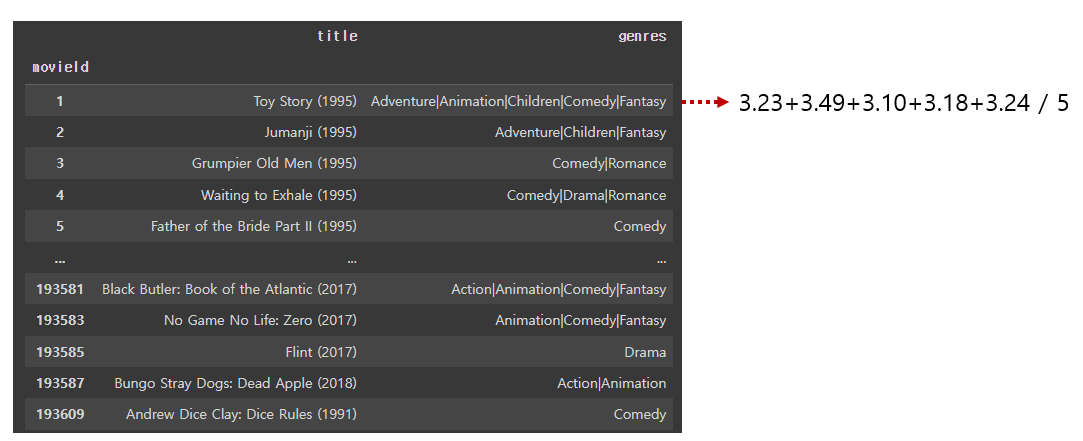

In [67]:
def get_genre_avg_ratings(x):    
    genres_list = movies_df.loc[x]['genres'].split('|')
    rating = 0
    for genre in genres_list:
        rating += genres_avg_ratings_df.loc[genre]['avg_ratings']    
    
    return rating / len(genres_list)

In [68]:
tqdm.pandas()
test_df['predict_rating_genre'] = test_df['movieId'].progress_apply(lambda x: get_genre_avg_ratings(x))

100%|██████████| 20168/20168 [00:04<00:00, 4112.81it/s]


In [69]:
test_df

,userId,movieId,rating,timestamp,predict_ratings_random,predict_rating_movie_avg,predict_rating_user_avg,predict_rating_genre
99731,610,3527,5.0,1479545223,4.0,3.604167,3.678709,3.138325
97583,606,1250,3.5,1171376891,0.5,4.180556,3.649718,3.410377
38197,262,213,5.0,840310907,1.0,3.750000,2.925000,3.429093
11474,68,69406,3.0,1261622505,2.0,3.571429,3.229331,3.267870
34105,232,4728,3.0,1218166950,2.5,2.769231,3.242268,3.181480
...,...,...,...,...,...,...,...,...
41080,279,593,4.0,1506394242,2.5,4.127907,3.666667,3.132440
4897,31,780,4.0,850466616,1.5,3.470760,3.911765,3.161424
8023,56,410,3.0,835799188,1.0,3.131148,3.837838,3.174323
77467,483,2291,4.0,1415579167,2.5,3.734375,3.598940,3.341203


In [70]:
mse = mean_squared_error(y_true=test_df['rating'].values, y_pred=test_df['predict_rating_genre'].values)
rmse = np.sqrt(mse)

print(mse, rmse)

1.1251906030478556 1.0607500191128236


### 3.5) 사용자 평균 평점기반 -> normalize 처리

- user의 평균 영화 평점을 normalize해서 확인하기, 평점 측정 수, 표준편차 등 **활용가능**

In [71]:
train_user_info_df = pd.DataFrame({
    'avg_ratings': train_df.groupby('userId')['rating'].mean(),
    'std_ratings': train_df.groupby('userId')['rating'].std(),
    'count_ratings': train_df.groupby('userId')['rating'].count()
})

train_user_info_df

,avg_ratings,std_ratings,count_ratings
userId,,,
1,4.320652,0.836600,184
2,3.940000,0.820569,25
3,2.516667,2.127340,30
4,3.631868,1.317823,182
5,3.636364,1.084498,33
...,...,...,...
606,3.649718,0.734887,885
607,3.772414,0.955574,145
608,3.145865,1.071503,665


In [72]:
#가중치 추가(feature 로 활용 가능성)
min_count = train_user_info_df['count_ratings'].min()
max_count = train_user_info_df['count_ratings'].max()
avg_count = train_user_info_df['count_ratings'].mean()

#train_user_info_df['weights'] = train_user_info_df['count_ratings'].apply(lambda x: (x-avg_count)/(max_count-min_count))
train_user_info_df['weights'] = train_user_info_df['count_ratings'].apply(lambda x: (x-min_count)/(max_count-min_count))

In [73]:
train_user_info_df

,avg_ratings,std_ratings,count_ratings,weights
userId,,,,
1,4.320652,0.836600,184,0.079740
2,3.940000,0.820569,25,0.006027
3,2.516667,2.127340,30,0.008345
4,3.631868,1.317823,182,0.078813
5,3.636364,1.084498,33,0.009736
...,...,...,...,...
606,3.649718,0.734887,885,0.404729
607,3.772414,0.955574,145,0.061660
608,3.145865,1.071503,665,0.302735


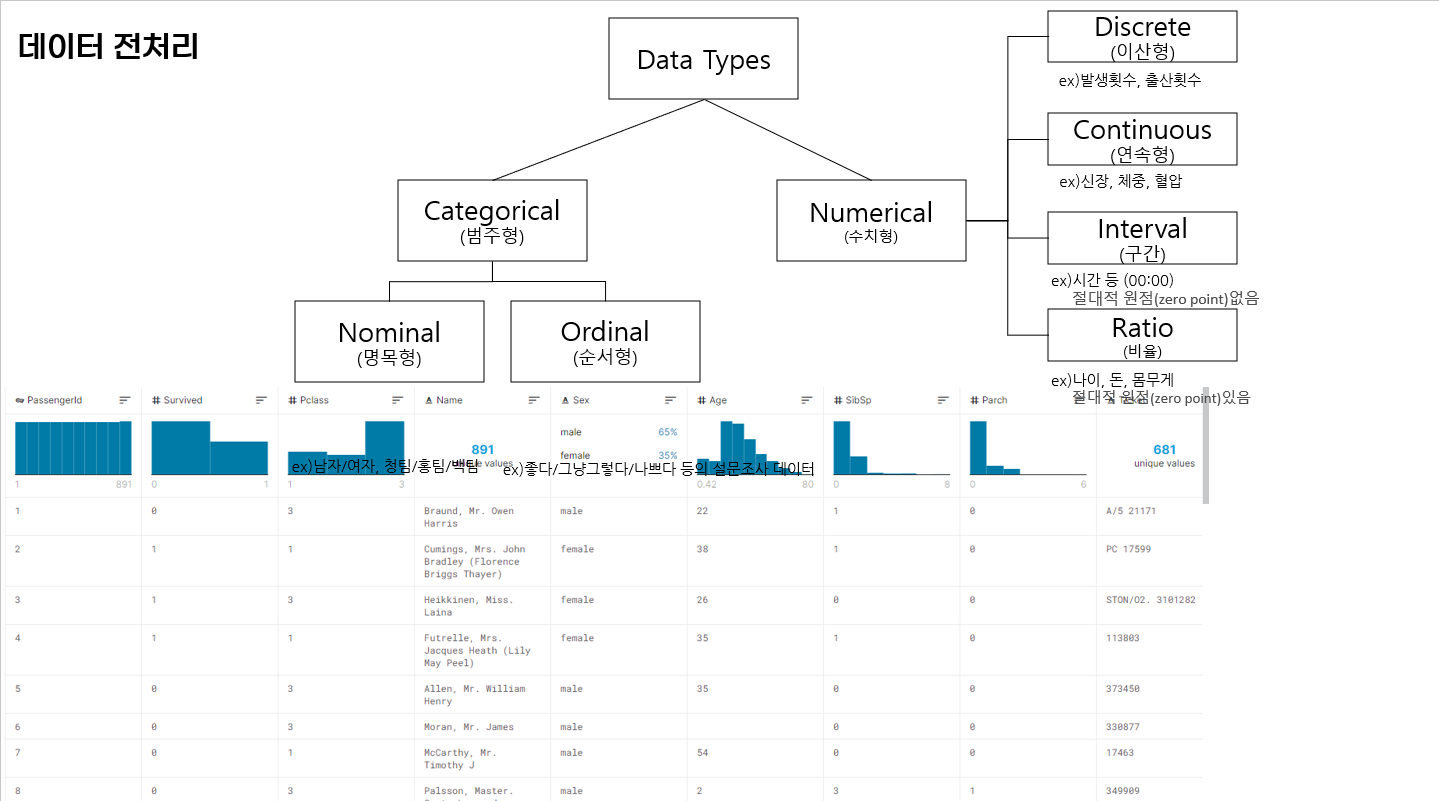

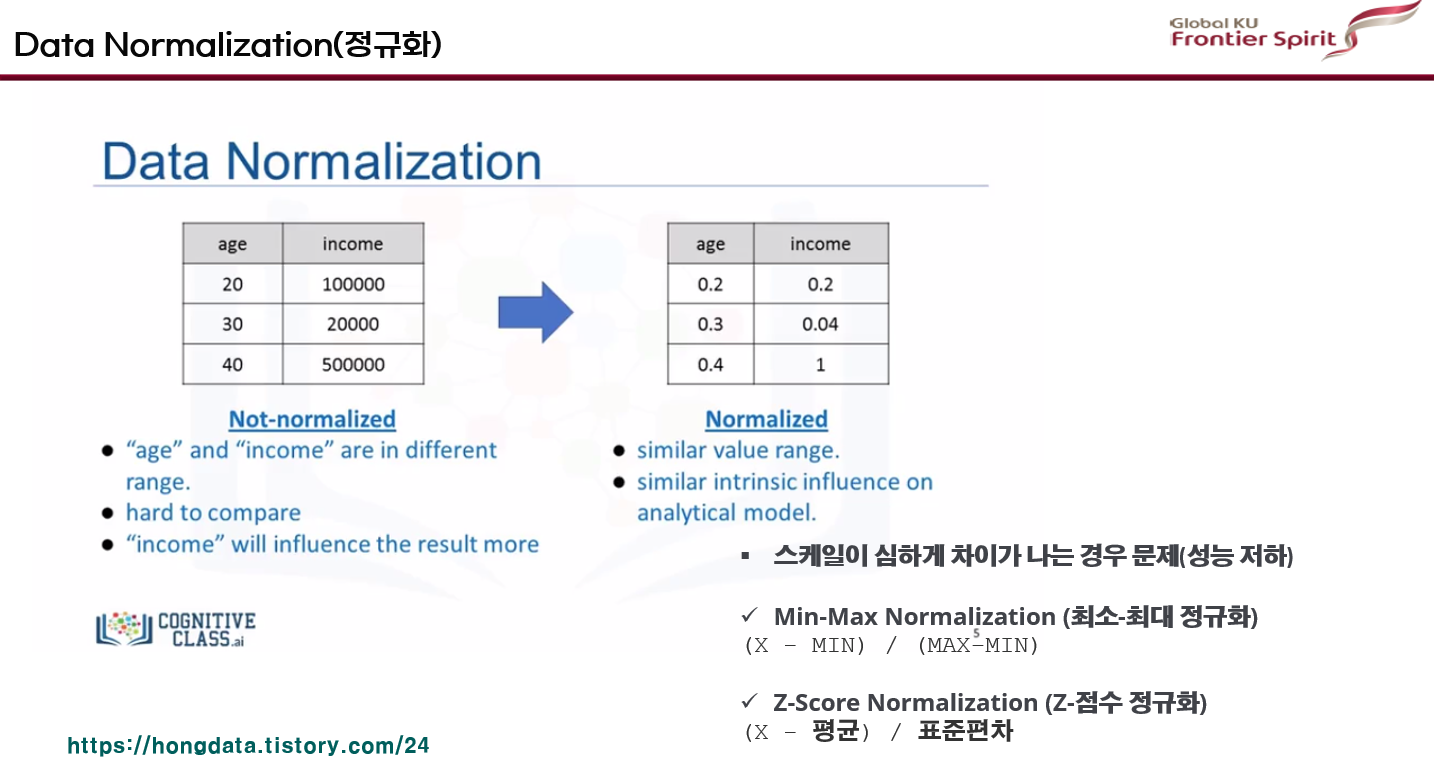


In [74]:
#Nominalization

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

np_scaled = min_max_scaler.fit_transform(train_user_info_df)
df_normalized = pd.DataFrame(np_scaled, columns = train_user_info_df.columns, index=train_user_info_df.index)
df_normalized

,avg_ratings,std_ratings,count_ratings,weights
userId,,,,
1,0.822227,0.393261,0.079740,0.079740
2,0.722617,0.385725,0.006027,0.006027
3,0.350156,1.000000,0.008345,0.008345
4,0.641984,0.619470,0.078813,0.078813
5,0.643161,0.509791,0.009736,0.009736
...,...,...,...,...
606,0.646655,0.345449,0.404729,0.404729
607,0.678762,0.449188,0.061660,0.061660
608,0.514806,0.503682,0.302735,0.302735


In [75]:
df_normalized['normalized_avg_ratings'] = df_normalized['avg_ratings'] * 5.5
df_normalized

,avg_ratings,std_ratings,count_ratings,weights,normalized_avg_ratings
userId,,,,,
1,0.822227,0.393261,0.079740,0.079740,4.522247
2,0.722617,0.385725,0.006027,0.006027,3.974393
3,0.350156,1.000000,0.008345,0.008345,1.925857
4,0.641984,0.619470,0.078813,0.078813,3.530913
5,0.643161,0.509791,0.009736,0.009736,3.537383
...,...,...,...,...,...
606,0.646655,0.345449,0.404729,0.404729,3.556603
607,0.678762,0.449188,0.061660,0.061660,3.733194
608,0.514806,0.503682,0.302735,0.302735,2.831431


In [76]:
test_df['predict_rating_normalized'] = test_df['userId'].apply(lambda x: df_normalized.loc[x]['normalized_avg_ratings'])
test_df

,userId,movieId,rating,timestamp,predict_ratings_random,predict_rating_movie_avg,predict_rating_user_avg,predict_rating_genre,predict_rating_normalized
99731,610,3527,5.0,1479545223,4.0,3.604167,3.678709,3.138325,3.598329
97583,606,1250,3.5,1171376891,0.5,4.180556,3.649718,3.410377,3.556603
38197,262,213,5.0,840310907,1.0,3.750000,2.925000,3.429093,2.513551
11474,68,69406,3.0,1261622505,2.0,3.571429,3.229331,3.267870,2.951560
34105,232,4728,3.0,1218166950,2.5,2.769231,3.242268,3.181480,2.970180
...,...,...,...,...,...,...,...,...,...
41080,279,593,4.0,1506394242,2.5,4.127907,3.666667,3.132440,3.580997
4897,31,780,4.0,850466616,1.5,3.470760,3.911765,3.161424,3.933755
8023,56,410,3.0,835799188,1.0,3.131148,3.837838,3.174323,3.827355
77467,483,2291,4.0,1415579167,2.5,3.734375,3.598940,3.341203,3.483521


In [77]:
mse = mean_squared_error(y_true=test_df['rating'].values, y_pred=test_df['predict_rating_normalized'].values)
rmse = np.sqrt(mse)

print(mse, rmse)

0.9593202185869494 0.9794489361814374
